<a href="https://colab.research.google.com/github/mcroning/Nonlinear-Beam-Propagation/blob/main/Copy_of_pr_coupler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import sys
import time
import os
import numpy as np
import random
from imageio.v2 import imread
from scipy.io import savemat,loadmat
from scipy import signal
from scipy.ndimage import zoom, gaussian_filter
import scipy.fft as spfft
from scipy.stats import expon
from scipy.optimize import curve_fit
import matplotlib
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image, ImageChops
from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [112]:
!git clone https://github.com/mcroning/Nonlinear-Beam-Propagation

fatal: destination path 'Nonlinear-Beam-Propagation' already exists and is not an empty directory.


In [113]:
class res:
    def __init__(self, imout, ampxz, amp, amp0):
        self.imout = imout
        self.ampxz = ampxz
        self.amp = amp
        self.amp0=amp0

In [134]:
# @title Set Parameters { run: "auto" }


gain_length_product = 6 # @param {type:"number"}
intensity_beam_ratio_2_to_1 = 0 # @param {type:"number"}
image_on_beam = "No Image" # @param ["No Image", "Image on beam 1"]
scattering_noise_type = "surface" # @param ["none", "surface"]
dark_intensity = 0.1 # @param {type:"number"}
relative_dielectric_constant = 2500 # @param {type:"number"}
mobile_charge_density = 6.4e22 # @param {type:"number"}
temperature_K = 293 # @param {type:"number"}
refractive_index = 2.4 # @param {type:"number"}
scattering_correlation_length_um = 0 # @param {type:"number"}
volume_noise_amplitude = 0.001 # @param {type:"number"}
surface_noise_amplitude = 0.1 # @param {type:"number"}
number_of_time_steps = 20 # @param {type:"integer"}
end_time_t0 = 4 # @param {type:"number"}
x_aperture_um = 2000.0 # @param {type:"number"}
y_aperture_um = 1000 # @param {type:"number"}
x_samples = "4096" # @param ["1024", "2048", "4096", "8192", "16384"]
y_samples = "512" # @param ["256", "512", "1024", "2048"]
interaction_length_um = 4000 # @param {type:"number"}
z_step_um = 100 # @param {type:"number"}

image_size_norm_by_waist1 = 1 # @param {type:"number"}
wavelength_um = 0.625 # @param {type:"number"}
beam_waist_1 = 200 # @param {type:"number"}
beam_waist_2 = 200 # @param {type:"number"}
external_angle_beam_1 = 0.16 # @param {type:"number"}
external_angle_beam_2 = -0.16 # @param {type:"number"}
azimuth_1 = 0 # @param {type:"number"}
azimuth_2 = 0 # @param {type:"number"}

Tukey_window_edge = 0.1 # @param {type:"number"}
image_type = "real image" # @param ["real image", "phase image"]


prop_random_steps = False # @param {type:"boolean"}
backpropagate_output_image = True # @param {type:"boolean"}
time_behavior = "Static" # @param ["Static", "Time Dependent"]
image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist0.png" # @param {type:"string"}
image_invert = True # @param {type:"boolean"}
fanning_study = True # @param {type:"boolean"}
prop_random=prop_random_steps
realimage=image_type=='phase_image'
refin=refractive_index
NT=mobile_charge_density
epsr=relative_dielectric_constant
T=temperature_K
Id=dark_intensity
gl=gain_length_product
sigma=scattering_correlation_length_um
noiseamp=volume_noise_amplitude
surfacenoise=surface_noise_amplitude
tsteps=number_of_time_steps
tend=end_time_t0
xaper=x_aperture_um
yaper=y_aperture_um
xsamp=int(x_samples)
ysamp=int(y_samples)
rlen=interaction_length_um
dz=z_step_um
image_size_factor=image_size_norm_by_waist1
lm=wavelength_um
w01=beam_waist_1
w02=beam_waist_2
thout1=external_angle_beam_1
thout2=external_angle_beam_2
phi1=azimuth_1
phi2=azimuth_2
rat=intensity_beam_ratio_2_to_1
windowedge=Tukey_window_edge
transp2=0
transp1=image_on_beam=="Image on beam 1"
noisetype=scattering_noise_type
backpropagate=backpropagate_output_image
timedep=time_behavior=="Time Dependent"
image_in=np.ones((28,28),dtype=np.uint8) #default image
if transp1==1 and os.path.exists(image_file_name):

  image_in = Image.open(image_file_name)
  if image_invert:
    image_in=ImageChops.invert(image_in)
  plt.imshow(image_in)
  image_in = np.asarray(image_in)
prdata={
    'prop_random':prop_random,
    'realimage':realimage,
    'data_in_size':200,
    'surfacenoise':surfacenoise,
    'epsr':epsr,
    'NT':NT,
    'T':T,
    'refin': refin,
    'noiseamp': noiseamp,
    'Id':Id,
    'sigma':sigma,
    'gl': gl,
    'xaper':xaper,
    'yaper':yaper,
    'xsamp':xsamp,
    'ysamp':ysamp,
    'rlen': rlen,
    'dz' : dz,
    'windowedge':windowedge,
    'lm':lm,
    'w01':w01,
    'w02':w02,
    'thout1':thout1,
    'thout2':thout2,
    'phi1':phi2,
    'phi2':phi1,
    'rat':rat,
    'transp1':transp1,
    'transp2':transp2,
    'backpropagate':backpropagate,
    'tsteps':tsteps,
    'tend':tend,
    'timedep':timedep,
    'image_size_factor':image_size_factor,
    'production':0,
    'noisetype':noisetype
}

In [135]:
dirName=os.getcwd()

niter=int(rlen/dz)
refin=prdata['refin']
lm=prdata['lm']
image_size_factor=prdata['image_size_factor']
w01=prdata['w01']
windowedge=prdata['windowedge']
NT=prdata['NT']
epsr=prdata['epsr']
q=1.602e-19
eps0=8.854e-12
kB=1.380649e-23
T=prdata['T']
noisetype=prdata['noisetype']
sigma=prdata['sigma']
thout1=prdata['thout1']
thout2=prdata['thout2']
phi1=prdata['phi1']
phi2=prdata['phi2']
x=np.linspace(-xaper/2,xaper/2,xsamp)
y=np.linspace(-yaper/2,yaper/2,ysamp)
z=np.linspace(0,rlen,niter)
dx=xaper/xsamp
dy=yaper/ysamp
dX=1/xaper
dY=1/yaper
dxy=dx*dy
dXY=dX*dY
xy=xsamp*ysamp
kin=2*np.pi*refin/lm
k0=q*np.sqrt(NT/(epsr*eps0*kB*T))*1e-6

# no space charge field in y direction right now

#data_in_size um (size of image to be applied to beams when called for)
#data_in_size=image_size_factor*w01
#prdata['data_in_size']=int(data_in_size)

# from Garrett and Warde JOSAB 9 1407 1992
# photorefractive characteristic grating wavenumber

# characteristic space charge field (See CG whole beam method paper)

fx=np.fft.fftfreq(xsamp,xaper/xsamp)
fy=np.fft.fftfreq(ysamp,yaper/ysamp)
fxy=np.zeros((xsamp,ysamp),dtype="float")
fxa=np.tile(fx,(len(fy),1)).T
fya=np.tile(fy,(len(fx),1))
fxy=(fxa**2+fya**2);
#calculate linear propagator
h=np.zeros((xsamp,ysamp),dtype="complex")
h= np.exp(2.0j*np.pi*refin*dz/lm*np.real(np.emath.sqrt(1-(lm/refin)**2*(fxy))))

##tukey window

windowx = signal.windows.tukey(xsamp,alpha=windowedge)
windowy = signal.windows.tukey(ysamp,alpha=windowedge)
windowxy=np.outer(windowx,windowy)
fwindowxy=np.fft.fftshift(windowxy)

#pseudorandom 3D noise array, uniform between -0.5 and 0.5

#sigma, noise correlation length microns, noiseamp amplitude of scatterers
#sigmax,y,x corresponding correlation length in terms of array units

sigmax=sigma*xsamp/xaper
sigmay=sigma*ysamp/yaper
sigmaz=sigma*niter/rlen

corrnoise1layer=np.random.rand(xsamp,ysamp)-0.5
corrnoise1layer=gaussian_filter(corrnoise1layer,sigma=(sigmax,sigmay))
    #corrnoise=np.random.rand(niter,xsamp,ysamp)-0.5
    #corrnoise=gaussian_filter(corrnoise,sigma=(sigmaz,sigmax,sigmay))

# define rotated coordinate systems
xp1=np.zeros((xsamp,ysamp))
yp1=np.zeros((xsamp,ysamp))
zp1=np.zeros((xsamp,ysamp))
xp2=np.zeros((xsamp,ysamp))
yp2=np.zeros((xsamp,ysamp))
zp2=np.zeros((xsamp,ysamp))

#empirical correction extra division by 2
el=rlen/2.0 #interaction length
th1=np.arcsin(np.sin(thout1)/refin)  #internal propagation angle
th2=np.arcsin(np.sin(thout2)/refin)
#x=xd #temp switch x to stretched

sp1=np.sin(phi1)
cp1=np.cos(phi1)
st1=np.sin(th1)
ct1=np.cos(th1)
s2p1=2*sp1*cp1
c2p1=cp1**2-sp1**2

sp2=np.sin(phi2)
cp2=np.cos(phi2)
st2=np.sin(th2)
ct2=np.cos(th2)
s2p2=2*sp2*cp2
c2p2=cp2**2-sp2**2

xa=np.tile(x,(len(y),1)).T
ya=np.tile(y,(len(x),1))

xp1=xa+cp1*(1-ct1)*(-xa*cp1+ya*sp1)-el*cp1*st1
yp1=ya+sp1*(1-ct1)*(xa*cp1-ya*sp1)+el*sp1*st1
zp1=(-el)*ct1+(-xa*cp1+ya*sp1)*st1
xp2=xa+cp2*(1-ct2)*(-xa*cp2+ya*sp2)-el*cp2*st2
yp2=ya+sp2*(1-ct2)*(xa*cp2-ya*sp2)+el*sp2*st2
zp2=(-el)*ct2+(-xa*cp2+ya*sp2)*st2


rotcoord=[xp1,yp1,zp1,xp2,yp2,zp2]
pr_setup=(rotcoord,h,windowxy)

In [136]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["animation.html"] = "jshtml"

fig = Figure(figsize=(10, 10), dpi=100)
fig1 = Figure(figsize=(5, 5), dpi=100)
ax1 = fig.add_subplot(121)
ax4 = fig.add_subplot(122)
ax2 = fig1.add_subplot(111)
fig2 = Figure(figsize=(5, 5), dpi=100)

ax5=fig2.add_subplot(111)

fig3 = Figure(figsize=(5, 5), dpi=100)
#canvas3=FigureCanvas(self.fig3)
ax6=fig3.add_subplot(111)

# try animation
fig4 = Figure(figsize=(5, 5), dpi=100)
#canvas4 = FigureCanvas(self.fig4)
ax10=fig4.add_subplot(111)


fig5 = Figure(figsize=(5, 5), dpi=100)
#canvas5 = FigureCanvas(self.fig5)
ax11=fig5.add_subplot(111)


In [137]:
#global prdata,X_train,maxsize,image_in,geom_orig


imsizex=np.shape(image_in)[0]  #find original x dimension of image
imsizey=np.shape(image_in)[1]  #find original y dimension
maxsize=max(imsizex,imsizey)   #find maximum side length, maxsize
if maxsize % 2 !=0: # make sure sides are of even length
     maxsize +=1
zoomsc=prdata['image_size_factor']*prdata['w01']/maxsize # find zoom factor for image to place it on beam 1
X_train=(zoom(image_in,(zoomsc*xsamp/xaper,zoomsc*ysamp/yaper)))/np.max(image_in) # scale input image to grid x y arrays, normalize to unity
fymax=ysamp/yaper/2

ax1.set_title('input image')
ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel(r'y ($\mu$m)')
ax1.set_xlim(-yaper/4,yaper/4)
ax1.set_ylim(-yaper/4,yaper/4)
ax2.clear()
ax2.set_title('intensity cross section')
ax2.set_xlabel(r'x ($\mu$m)')
ax2.set_ylabel(r'z ($\mu$m)')
#self.ax2.set_xlim(-prdata['xaper']/2,prdata['xaper']/2)
#self.ax2.set_ylim(-prdata['yaper']/2,prdata['yaper']/2)
#self.ax2.set_ylim(prdata['rlen'],0)
ax4.set_title('output image')
ax4.set_xlabel(r'x ($\mu$m)')
ax4.set_ylabel(r'y ($\mu$m)')
ax4.set_xlim(-yaper/4,yaper/4)
ax4.set_ylim(-yaper/4,yaper/4)
#cb=plt.colorbar(img, ax=self.ax4)

#self.fig.tight_layout()

(-250.0, 250.0)

In [138]:
#global prdata,pr_setup,corrnoise,X_train,ampxz,resout,imout_final,gain,ift,imin,corrnoise1layer,imout,gain_seq,t_seq,dzs,amp
#global mask1,mask2,mask1a,mask2a
#ampxz: transverse amplitude cross section (complex) [nsteps//4,xsamp,ysamp]
#resout: carries results for production version  (maybe needs only hold imout for deep learning)
#imout_final: square sample of output on beam 1 (positive frequencies) (currently size yaper/2)
#imin: input intensity matching imout_final
#gain: calculated coupling gain for two beam coupling
#ift: far field intensity (float) [nsteps,xsamp,ysamp]
#corrnoise: 3D noise array for optical scattering (not in use)
#corrnoise1layer: 2D noise array for surface scattering
#prdata: dictionary containing variables and parameters
#pr_setup: tuple containing rotcoord rotated coordinates for beam angle, h optical propagator for uniform material, w Tukey window

rotcoord=pr_setup[0]
h=pr_setup[1]
windowxy=pr_setup[2]
#import warnings
#warnings.filterwarnings("error")
noisetype=prdata['noisetype']
arrin=X_train/np.max(abs(X_train))
def image(x,y,arrin,prdata):
    xmin=-prdata['w01']*prdata['image_size_factor']/2
    xsamp=prdata['xsamp']
    ysamp=prdata['ysamp']
    xmax=-xmin
    ymin=xmin  #square image
    ymax=xmax  #square image
    xmag=np.abs(x[:,0]) #x is striped in y, so x lives in first coordinate of x array
    ymag=np.abs(y[0,:]) #y is striped in x, so y lives in second coordinate of y array
    xcenter=np.argmin(xmag) #find where x = 0, beam transverse center
    ycenter=np.argmin(ymag) #find where x = 0, beam transverse center
    jxs,jys=np.shape(arrin)
    arrin_n=arrin/np.max(arrin) #normalize image

    arrinz=zoom(arrin,(xsamp*xmax*2/xaper/jxs,ysamp*ymax*2/yaper/jys)) #zoom image to size xmax*xmax microns
    jxsz,jysz=np.shape(arrinz)
    aout=np.ones((xsamp,ysamp)) # default transparent uniform image covering full field
    #xb,xu,yb,yu upper and lower indices of zoomed image in full tranparency
    xb=int((xsamp-jxsz)/2)
    xu=xb+jxsz
    yb=int((ysamp-jysz)/2)
    yu=yb+jysz

    aout[xb:xu,yb:yu]=arrinz #place image at center of full field
    aout=np.roll(aout,-xsamp//2+xcenter,axis=0) #roll image to be centered on beam 1 center
    aout=np.roll(aout,-ysamp//2+ycenter,axis=1) #roll image to be centered on beam 1 center

    return aout

def gaus(x,y,z,beam,arrin,prdata,w0x,w0y):
    #x,y,z rotated coordinates, beam = beam number 1 or 2
    arrin=arrin/(np.max(arrin))  #assuming real transparency for now
    lm=prdata['lm']
    rlen=prdata['rlen']
    refin=prdata['refin']
    refin=prdata['refin']
    xsamp=prdata['xsamp']
    ysamp=prdata['ysamp']
    xaper=prdata['xaper']
    yaper=prdata['yaper']

    dx=xaper/xsamp
    dy=yaper/ysamp
    thout1=prdata['thout1']
    thout2=prdata['thout2']
    th1=np.arcsin(np.sin(thout1)/refin)
    th2=np.arcsin(np.sin(thout2)/refin)
    phi1=prdata['phi1']
    phi2=prdata['phi2']
    #x1=rlen*np.tan(th1)/2*np.cos(phi1) #twice the axis rotationaxis z location from mathematica
    #y1=rlen*np.tan(th1)*np.sin(phi1)
    kout=2*np.pi/lm
    kin=refin*kout
    z0x=w0x**2*kin/2.0
    z0y=w0y**2*kin/2.0
    eta=(np.arctan(z/z0x)+np.arctan(z/z0y))/2
    rlxinv=z/(z**2+z0x**2)
    rlyinv=z/(z**2+z0y**2)
    rlxinvmn=rlen/(rlen**2+z0x**2) #mean radius of curvature
    wl2x=w0x**2*(1.0+(z/z0x)**2)
    wl2y=w0y**2*(1.0+(z/z0y)**2)
    wlxy=np.sqrt((1.0+(z/z0x)**2)*(1.0+(z/z0y)**2))
    xmax=np.pi/(kin*dx*rlxinvmn)
    amp1 = np.zeros((xsamp,ysamp),dtype='complex')
    argx = ((x)**2)*(1.0/wl2x-1j*kin*rlxinv/2.0)
    argy = (y**2)*(1.0/wl2y-1j*kin*rlyinv/2.0)
    arg=argx+argy
    amp1 = np.exp(-arg+1j*kin*z-1j*eta)/np.sqrt(wlxy)
    transp1=prdata['transp1']
    transp2=prdata['transp2']

    phasetransp=prdata['realimage']  #apply data as phase transparency if false
    # beam may have the data transparency imposed
    #apply image on beam 1
    applytransp=transp1==1

    if applytransp and not phasetransp and beam==1:
        amp1=amp1*image(x,y,arrin,prdata)
    elif applytransp and phasetransp and beam==1:
        amp1=amp1*np.exp(2j*np.pi*image(x,y,arrin,prdata))
    return amp1

def a(arrin,prdata,offset,rotcoord):
    #offset True then shift z by delta z for derivative d/dz calc
    rat=prdata['rat']
    a1r=1.0/np.sqrt(1.0+rat)
    a2r=np.sqrt(rat)/np.sqrt(1.0+rat)

    xp1=rotcoord[0]
    yp1=rotcoord[1]
    zp1=rotcoord[2]
    xp2=rotcoord[3]
    yp2=rotcoord[4]
    zp2=rotcoord[5]
    transp1=prdata['transp1']
    transp2=prdata['transp2']
    w0x1=prdata['w01']
    w0y1=prdata['w01']
    w0x2=prdata['w02']
    w0y2=prdata['w02']

    if offset==False:
        amp1=gaus(xp1,yp1,zp1,1,arrin,prdata,w0x1,w0y1)
        amp2=gaus(xp2,yp2,zp2,2,arrin,prdata,w0x2,w0y2)
    else: #unused, for fdbpm
        amp1=gaus(xp1dz,yp1dz,zp1dz,transp1,arrin,prdata,w0x1,w0y1)
        amp2=gaus(xp2dz,yp2dz,zp2dz,transp2,arrin,prdata,w0x2,w0y2)

    atot=a1r*amp1+a2r*amp2
    print(a1r,a2r)
    print(rat)
    return atot


In [139]:

#start main propagation
#tracemalloc.start()
rlen=prdata['rlen']
lm=prdata['lm']  #wavelength
refin=prdata['refin'] #refractive index
kout=2*np.pi/lm      #external wavenumber
kin=refin*kout
thout1=prdata['thout1']
thout2=prdata['thout2']
prop_random=prdata['prop_random']
gl=prdata['gl']
fx=np.fft.fftfreq(xsamp,xaper/xsamp)
fxx=np.tile(fx,(ysamp,1)).T  #tiled x frequencies
Id=prdata['Id']
th1=np.arcsin(np.sin(thout1)/refin)
th2=np.arcsin(np.sin(thout2)/refin)
NT=prdata['NT']
q=1.602e-19
eps0=8.854e-12
kB=1.380649e-23
epsr=prdata['epsr']
T=prdata['T']
k0=q*np.sqrt(NT/(epsr*eps0*kB*T))*1e-6 #characteristic photorefractive wavenumber
Es=q*NT/(epsr*eps0*k0*1e6)             #characteristic space charge field
th1=np.arcsin(np.sin(thout1)/refin)
th2=np.arcsin(np.sin(thout2)/refin)
alpha=0
dz=prdata['dz']
niter=int(rlen/dz)
noiseamp=prdata['noiseamp']
phi1=prdata['phi1']
phi2=prdata['phi2']
dx=xaper/xsamp
dy=yaper/ysamp
xp1=rotcoord[0]
yp1=rotcoord[1]
zp1=rotcoord[2]
xp2=rotcoord[3]
yp2=rotcoord[4]
zp2=rotcoord[5]

xmag1=np.abs(xp1[:,0]) #x is striped in y, so x lives in first coordinate of x array
ymag1=np.abs(yp1[0,:]) #y is striped in x, so y lives in second coordinate of y array
x1=(np.argmin(xmag1)-xsamp//2)*dx #find where x = 0, beam transverse center
y1=(np.argmin(ymag1)-ysamp//2)*dy #find where x = 0, beam transverse center

xmag2=np.abs(xp2[:,0]) #x is striped in y, so x lives in first coordinate of x array
ymag2=np.abs(yp2[0,:]) #y is striped in x, so y lives in second coordinate of y array
x2=(np.argmin(xmag2)-xsamp//2)*dx #find where x = 0, beam transverse center
y2=(np.argmin(ymag2)-ysamp//2)*dy #find where x = 0, beam transverse center
x1a=rlen*np.tan(th1)/2*np.cos(phi1) #twice the axis rotationaxis z location from mathematica
y1a=-rlen*np.tan(th1)/2*np.sin(phi1)
#image on beam 1 appears at output at -x1
x2a=rlen*np.tan(th2)/2*np.cos(phi2) #twice the axis rotationaxis z location from mathematica
y2a=-rlen*np.tan(th2)/2*np.sin(phi2)
#image on beam 2 appears at output at -x2
amp0=np.zeros((xsamp,ysamp),dtype="complex")
ampp=np.zeros((xsamp,ysamp),dtype="complex")
ampm=np.zeros((xsamp,ysamp),dtype="complex")
fx1=-np.cos(phi1)*np.tan(thout1)/np.sqrt(1+(np.cos(phi1)*np.tan(thout1))**2)/lm
fy1=np.sin(phi1)*np.tan(thout1)/np.sqrt(1+(np.sin(phi1)*np.tan(thout1))**2)/lm
fx2=-np.cos(phi2)*np.tan(thout2)/np.sqrt(1+(np.cos(phi2)*np.tan(thout2))**2)/lm
fy2=np.sin(phi2)*np.tan(thout2)/np.sqrt(1+(np.sin(phi2)*np.tan(thout2))**2)/lm
mask1=np.zeros((xsamp,ysamp))
mask2=np.zeros((xsamp,ysamp))

for j in range(ysamp):
    fy=(j-ysamp//2)/yaper
    for k in range(xsamp):
        fx=(k-xsamp//2)/xaper
        Df1=(fx-fx1)**2+(fy-fy1)**2
        Df2=(fx-fx2)**2+(fy-fy2)**2

        if Df1<=Df2:
            mask1[k,j]=1
        else:
            mask2[k,j]=1

mask1=np.fft.fftshift(mask1)
mask2=np.fft.fftshift(mask2)

amp0=a(arrin,prdata,False,rotcoord)
print('ratout',rat,prdata['rat'])
amp0p=np.fft.ifft2(np.fft.fft2(amp0)*mask2)  #positive spatial frequency input field (beam 2 spatial frequencies)
amp0m=np.fft.ifft2(np.fft.fft2(amp0)*mask1)  #negative spatial frequency input field
ip0r=np.sum(abs(amp0p)**2)  #input beam 2 intensity
im0r=np.sum(abs(amp0m)**2)  #input beam 1 intensity
xl=(xsamp/2*(1-yaper/xaper/2)) #xl(ow), xh(igh), x indices for square sample of output
xh=(xsamp/2*(1+yaper/xaper/2))
yl=int(ysamp/2*(1-1/2)) # take half output in y extent
yh=int(ysamp/2*(1+1/2))
imcenter0=abs(amp0m[int(xl+x1/dx):int(xh+x1/dx),int(yl+y1/dy):int(yh+y1/dy)])**2 #big sample of negative frequencies (beam 1)
lx,ly=np.shape(imcenter0)
imin=imcenter0 #imin : image in
amp=amp0*1.0  #working optical amplitude

#for speed generate noise in program, not from corrnoise stored in prdata
#rng=np.random.default_rng(seed=3931) #fix seed 53
####corrnoise=np.zeros((xsamp,ysamp)) @restore full correlated noise 7/5
#sigma=prdata['sigma']
#sigmax=sigma/dx
#sigmay=sigma/dy

tsteps=prdata['tsteps'] #number of time steps
tend=prdata['tend'] # end time
kt=0  #nonlinearity proportional to intensity to model temperature

### ampft=np.zeros((tsteps,xsamp,ysamp),dtype=complex) DEL

escsfull=np.zeros((niter,xsamp,ysamp),dtype=float)   #full 3D space charge field
escsprev=np.zeros((niter,xsamp,ysamp),dtype=float)
escsp=np.zeros((xsamp,ysamp),dtype=float)      #full space charge x gradient
escspp=np.zeros((xsamp,ysamp),dtype=float)     #full space charge 2nd derivative
Delta=np.zeros((xsamp,ysamp),dtype=float)      #change in space charge field over one time step
####corrnoise=rng.random((xsamp,ysamp))-0.5 #deleted 7/5
####corrnoise=gaussian_filter(corrnoise,sigma=(sigmax,sigmay))  # deleted 7/5
fwindowxy=np.fft.fftshift(windowxy) #Tukey window for FT
eflag=0
errout=0
errind=np.zeros(2)

timedep=prdata['timedep']

deltat=0.0
if prdata['timedep']==True:
    tsteps=prdata['tsteps']
    tsteps=4*tsteps//4

    tend=prdata['tend']
    deltat=tend/tsteps

    t_seq=np.linspace(deltat,tend,tsteps)
    escsxz=np.zeros((tsteps//4,niter,xsamp))
    ampout=np.zeros((tsteps//4,xsamp,ysamp),dtype=complex)
    ampxz=np.zeros((tsteps//4,niter,xsamp),dtype=complex)
else:
    tsteps=1
    escsxz=np.zeros((1,niter,xsamp))
    ampout=np.zeros((1,xsamp,ysamp),dtype=complex)
    ampxz=np.zeros((1,niter,xsamp),dtype=complex)
gain_seq=np.zeros(tsteps)
#x1=prdata['rlen']*np.tan(th1)/2
#image on beam 1 appears at output at -x1
#x2=prdata['rlen']*np.tan(th2)/2
backpropagate=prdata['backpropagate']
#Step over time in jt

#generate exponentially distributed propagation steps
dzs=expon.rvs(scale=dz, size=niter)
dzs=dzs/np.sum(dzs)*rlen
#generate sum of squares of x and y frequencies for use in proagators h2 for the propagation steps
fx=np.fft.fftfreq(xsamp,xaper/xsamp)
fy=np.fft.fftfreq(ysamp,yaper/ysamp)
fxy=np.zeros((xsamp,ysamp),dtype="float")
fxa=np.tile(fx,(len(fy),1)).T
fya=np.tile(fy,(len(fx),1))
fxy=(fxa**2+fya**2);


1.0 0.0
0
ratout 0 0


In [140]:

for jt in range(tsteps):

        #Set input field to amp0
        amp=amp0*1.0

        #Calculate and apply surface noise
        if noisetype=='surface':
            dn= 1+prdata['surfacenoise']*corrnoise1layer #0.1 too much 3removed 7/5  one layer  no indexing [0]
            amp=amp*np.exp(1.0j*2*np.pi*dn)
        #begin z propagation
        #c=(3*np.random.rand(niter)).astype(np.uint8)
        tic=time.perf_counter()
        for i in range(niter):
            if prop_random:
                h2=np.exp(2.0j*np.pi*refin*dzs[i]/lm*np.real(np.emath.sqrt(1-(lm/refin)**2*(fxy))))
                amp=spfft.fft2(amp,workers=-1)*h2*fwindowxy # fwindowxy
            else:
                # Uniform prop function here one dz step
                amp=spfft.fft2(amp,workers=-1)*h*fwindowxy # fwindowxy
            # Uniform prop function here one dz step

            amp=spfft.ifft2(amp,workers=-1)
            # Calculate intensity
            intens2=abs(amp)**2
            escft=spfft.fft(escsfull[i,:],axis=0,workers=-1)
            # Calculate transverse derivative of space charge field from previous step
            escsp=np.real(spfft.ifft((2j*np.pi*fxx/k0)* escft ,axis=0,workers=-1))
            # Caluculate second derivative of space charge field from previous step
            escspp=np.real(spfft.ifft((2j*np.pi*fxx/k0)**2* escft ,axis=0,workers=-1))
            # Calculate derivative of intensity
            Ip=np.real(spfft.ifft(1.0j*2*np.pi*fxx*spfft.fft(intens2,axis=0,workers=-1),axis=0,workers=-1))/k0
            # Calculate change Delta in Esc using previous esc and current intensity
            try:
                Delta=-((escsfull[i,:]*(intens2+Id)-Ip)*(1+escsp)-escspp*(intens2+Id))
            except:

                if eflag ==0:

                    errout=res(escsfull, intens2, escsp[i-1,:], escspp[i-1,:])
                    errind[0]=i
                    errind[1]=jt
                eflag=1
                Delta=intens2*0

            if timedep==True:  #update space charge field
                escsprev[i,:]=escsfull[i,:]*1.0
                if jt ==0:
                    escsfull[i,:]= escsfull[i,:]+deltat*Delta
                else:
                    escsfull[i,:]= escsfull[i,:]*4/3 - escsprev[i,:]/3 + deltat*Delta
            else:
                # Space charge field from steady state PR theory
                escsfull[i,:]=-np.real(spfft.ifft(-spfft.fft(Ip/(intens2+Id),axis=0,workers=-1)/(1+(2.0*np.pi*fxx/k0)**2),axis=0,workers=-1) )

            dn= -escsfull[i,:]*gl/(rlen*kout) #photorefractive index array
            #disable volume noise
            #if noisetype=='volume':
            #   dn=dn+noiseamp*corrnoise[i]+kt*intens2    #kt a thermal contribution
            #apply appropriate photorefractive phase change
            if prop_random:
                amp=amp*np.exp(1.0j*kin*dn*dzs[i])*windowxy
            else:
                amp=amp*np.exp(1.0j*kin*dn*dz)*windowxy
            ampft=spfft.fft2(amp,workers=-1)
            ampp=spfft.ifft2(ampft*mask2,workers=-1)  #beam 2 intensity
            ampm=spfft.ifft2(ampft*mask1,workers=-1)  #beam 1 intensity
            imr=np.sum(np.sum(abs(ampm)**2)) # beam 2 total power
            ipr=np.sum(np.sum(abs(ampp)**2)) # beam 1 total power


            gain_seq[jt]=-np.log(imr/im0r/(ipr/ip0r)) /2
            if jt%4==0:
                ampxz[jt//4,i,:]=amp[:,ysamp//2]  #store every 4th cross section and amplitude
                ampout[jt//4]=amp # store every fourth time dependent amplitude



        #end z step loop code at time step jt

        toc=time.perf_counter()
        cycle_time=toc-tic

        #ampp=np.fft.ifft2(np.fft.fft2(amp)*mask2) #positive freqiency beam 2
        #ampm=np.fft.ifft2(np.fft.fft2(amp)*mask1) #negative frequency beam 1
        iftstep=abs(np.fft.fftshift(spfft.fft2(amp,workers=-1)))**2  #far field

        #ipr=np.sum(abs(ampp)**2)
        #imr=np.sum(abs(ampm)**2)
        gain=-np.log(imr/im0r/(ipr/ip0r))/2
        #imcenter=abs(ampm[int(xl-x1/dx):int(xh-x1/dx),yl:yh])**2 #big sample beam 1
        imcenter=abs(ampm[int(xl-x1/dx):int(xh-x1/dx),int(yl-y1/dy):int(yh-y1/dy)])**2 #big sample of negative frequencies (beam 1)
        if jt==0:
            ift=iftstep
            imout=imcenter #imout : image out
        elif jt%4==0:
            ift=np.concatenate((ift,iftstep))
            imout=np.concatenate((imout,imcenter))
        #back propagate to see effect on image
        if backpropagate:
            ampb=amp*1.0
            x1b=-x1
            y1b=-y1

            for i in range(niter):
                ampb=spfft.fft2(ampb)*np.conj(h)*fwindowxy # fwindowxy
                ampb=spfft.ifft2(ampb)*windowxy
            ampbft=spfft.fft2(amp,workers=-1)
            ampbp=spfft.ifft2(ampft*mask2,workers=-1)  #beam 2 intensity
            ampbm=spfft.ifft2(ampft*mask1,workers=-1)  #beam 1 intensity
            #ampbp=np.fft.ifft2(np.fft.fft2(ampb)*mask2)
            #ampbm=np.fft.ifft2(np.fft.fft2(ampb)*mask1)
            #imcenterb=abs(ampbm[int(xl-x1b/dx):int(xh-x1b/dx),yl:yh])**2 #big sample not p
            imcenterb=abs(ampbm[int(xl-x1b/dx):int(xh-x1b/dx),int(yl-y1b/dy):int(yh-y1b/dy)])**2 #big sample of beam 1
            if jt==0:
                imoutb=imcenterb
            elif jt%4==0:
                imoutb=np.concatenate((imoutb,imcenterb))

#End t step loop


if prdata['timedep']==True:
    imout=np.reshape(imout,(jt//4+1,lx,ly))
    imout=zoom(imout,(1,yaper/xaper,1)) #zoom image arrays so they appear square
    ift=np.reshape(ift,(jt//4+1,xsamp,ysamp))
else:
    imout=np.reshape(imout,(1,lx,ly))
    imout=zoom(imout,(1,yaper/xaper,1))
    ift=np.reshape(ift,(1,xsamp,ysamp))

#imout, ampxz, amp, amp0i
#ixz=abs(ampxz[-1])**2


if backpropagate:
    if prdata['timedep']==True:
        imoutb=np.reshape(imoutb,(jt//4+1,lx,ly))
        imout=zoom(imoutb,(1,yaper/xaper,1))
    else:
        imoutb=np.reshape(imoutb,(1,lx,ly))
        imout=zoom(imoutb,(1,yaper/xaper,1))

imin=zoom(imin,(yaper/xaper,1))
resout=res(imout, ampxz, amp, amp0)  #for imout measurement
#production=False
#if production:
    #return imout
#else:
    #return resout


In [141]:
def func(x, a, b): #exponential gain fit
    return a * np.exp(-b * x) - a

x=np.linspace(-xaper/2,xaper/2,xsamp)
w01=prdata['w01']
w02=prdata['w02']
niter=int(rlen/prdata['dz'])
tsteps=prdata['tsteps']
thout1=prdata['thout1']
thout2=prdata['thout2']
lm=prdata['lm']
lxf=ift.shape[1]
if prdata['timedep']==0:
    tsteps=1
lbf=int(lxf*(1-xaper/yaper*ysamp/xsamp)/2) #assuming yaper<xaper
luf=int(lxf*(1+xaper/yaper*ysamp/xsamp)/2)


zs=np.zeros(niter)
zs[0]=0
for i in range(1,niter):
 zs[i]=zs[i-1]+dzs[i]
z=np.linspace(0,rlen,niter)
ixz=abs(ampxz)**2

if prdata['prop_random']:

 #for i in range(tsteps//4)
    for i in range(np.shape(ixz)[0]):
         for j in range(xsamp):
            ixz[i,:,j]=np.interp(z,zs,ixz[i,:,j])
maskmid=int(-xaper*(np.sin(thout1)+np.sin(thout2))/(2*lm))+xsamp//2
#mask1=np.zeros((xsamp,ysamp))  #10/5/23
#mask2=np.zeros((xsamp,ysamp))
#mask1[0:maskmid,:]=1
#mask2[maskmid:-1,:]=1

imout_final=imout[-1]

imin_final=imin
ixzf=np.abs(ampxz[0])**2

ixzf=ixz[0]
u16max=65535
if prdata['timedep']==True:

    vmaxim=np.max(imout)
    vmaxixz=np.max(ixz)
    imout=imout/vmaxim*u16max
    imout=imout.astype(np.uint16)
    imoutT=imout.T
    imoutT=np.ascontiguousarray(imoutT)
    ixz=ixz/vmaxixz*u16max
    ixz=ixz.astype(np.uint16)
    ax6.plot(t_seq,gain_seq)
 #self.canvas3.draw()
    popt, pcov = curve_fit(func, t_seq, gain_seq)
    print('popt,pcov',popt,pcov)


 # try animation
    ims=[]

    ax10.clear()

    for i in range(np.shape(ixz)[0]):
        im=ax10.imshow(ixz[i],aspect='auto',vmax=u16max,extent=[-xaper/2000,xaper/2000,rlen/1000,0])
        if i ==0:
            ax10.imshow(abs(ixz[i]),aspect='auto',vmax=u16max,extent=[-xaper/2000,xaper/2000,rlen/1000,0])
            ax10.set_xlabel('x mm')
            ax10.set_ylabel('y mm')
            ax10.set_title( r'$\gamma$l '+str(prdata['gl']))
        ims.append([im])
    ani1 = animation.ArtistAnimation(fig4, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    video=ani1.to_jshtml()
    html=display.HTML(video)
    display.display(html)



     #self.canvas4.draw()

    ims=[]
    ax11.clear()
     #for i in range(tsteps//4):
    for i in range(np.shape(imout)[0]):
         #imout spans 0.5 yaper
        ymax=yaper/1000/2/2 # in mm 1st /2 is for haly ya aperture spanning, 2nd /2 is for zero centered yaper
        im=ax11.imshow(abs(imout[i].T),aspect='auto',vmax=u16max,extent=[-ymax,ymax,-ymax,ymax])
        if i ==0:
            ax11.imshow(abs(imout[i].T),aspect='auto',vmax=u16max,extent=[-ymax,ymax,-ymax,ymax])
            ax11.set_xlabel('x mm')
            ax11.set_ylabel('y mm')
            ax11.set_title( r'$\gamma$l '+str(prdata['gl']))
        ims.append([im])
    ani2 = animation.ArtistAnimation(fig5, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    video=ani2.to_jshtml()
    html=display.HTML(video)
    display.display(html)

 #self.canvas5.draw()

ax1.set_title('input image')
ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel(r'y ($\mu$m)')
ax1.set_xlim(-yaper/4,yaper/4)
ax1.set_ylim(-yaper/4,yaper/4)
img=ax1.imshow(imin_final.T,extent=[-yaper/4,yaper/4,-yaper/4,yaper/4])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(img,cax=cax)
ax2.imshow(ixzf,extent=[-xaper/2,xaper/2,prdata['rlen'],0],aspect=1)

#self.ax2.imshow(abs(amp)**2,aspect='auto')
#self.fig.tight_layout()
ax4.clear()
ax4.set_title('output image')
ax4.set_xlabel(r'x ($\mu$m)')
ax4.set_ylabel(r'y ($\mu$m)')
img=ax4.imshow(imout_final.T,extent=[-yaper/4,yaper/4,-yaper/4,yaper/4])
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)

#cb=
plt.colorbar(img,cax=cax)
#cb.remove()
#self.canvas.draw()
gainstr='{0:.2f}'.format(gain)


iftf=ift[-1] #output far field
fymax=ysamp/yaper/2
fxmax=xsamp/xaper/2
vscale=xsamp/xaper*yaper/ysamp
w01=prdata['w01']
w02=prdata['w02']
phi1=prdata['phi1']
phi2=prdata['phi2']
#fanning_mask
ws=min(w01,10)
fx=-np.cos(phi1)*np.tan(thout1)/np.sqrt(1+(np.cos(phi1)*np.tan(thout1))**2)/lm
fy=np.sin(phi1)*np.tan(thout1)/np.sqrt(1+(np.sin(phi1)*np.tan(thout1))**2)/lm
maskxp=int(xaper*(fx+1/ws/2))+xsamp//2
maskxm=int(xaper*(fx-1/ws/2))+xsamp//2
maskyp=int(yaper*(fy+1/ws/2))+ysamp//2
maskym=int(yaper*(fy-1/ws/2))+ysamp//2
mask=np.ones((xsamp,ysamp))
mask[maskxm:maskxp,maskym:maskyp]=0
faneff=np.sum(mask*iftf)/np.sum(iftf)
fanstr='{0:.2f}'.format(faneff)

fm=np.unravel_index(np.argmax(iftf),np.shape(iftf))

if fanning_study==True:
    ax5.clear()
    ax5.imshow((mask*iftf).T,extent=[-fxmax,fxmax,-fymax,fymax],cmap='terrain')

else:
    ax5.clear()
    ax5.imshow(iftf.T,extent=[-fxmax,fxmax,-fymax,fymax],cmap='terrain')

ax5.set_xlabel( r'x spatial frequency ($\mu m^{-1}$)')
ax5.set_ylabel( r'y freq ($\mu m^{-1}$)')
ax5.set_title( r'$\gamma$l '+str(prdata['gl']))


Text(0.5, 1.0, '$\\gamma$l 6')

<Figure size 640x480 with 0 Axes>

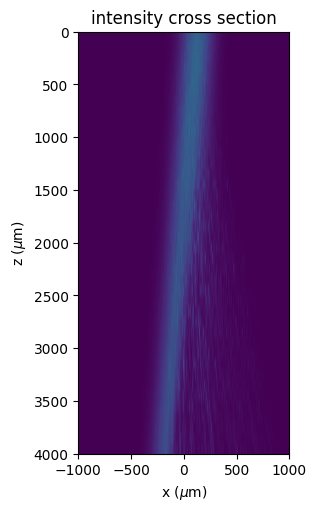

In [142]:
fig1

In [129]:
transp1

False

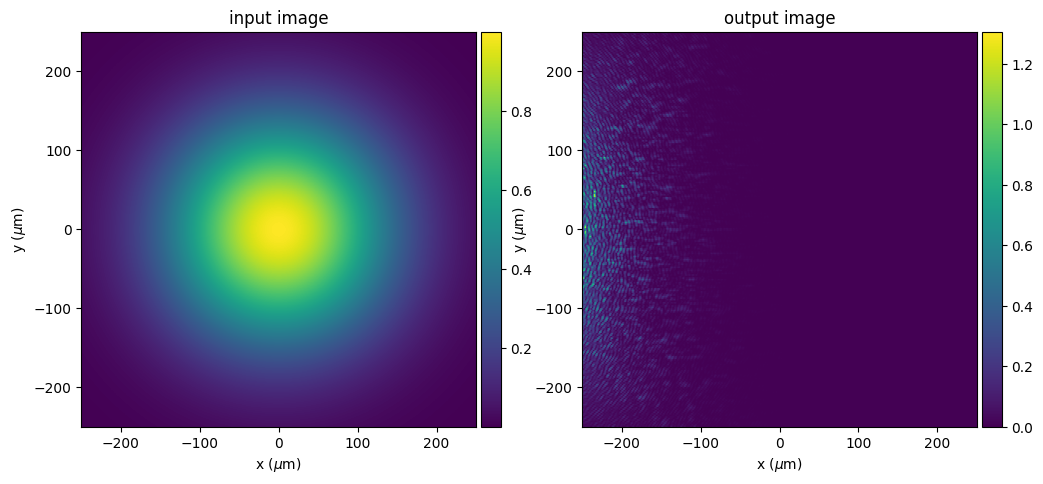

In [143]:
fig

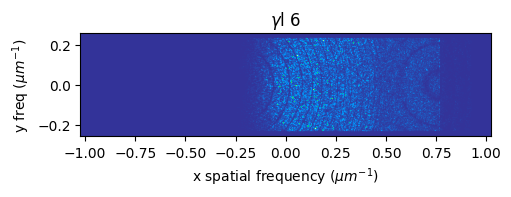

In [144]:
fig2

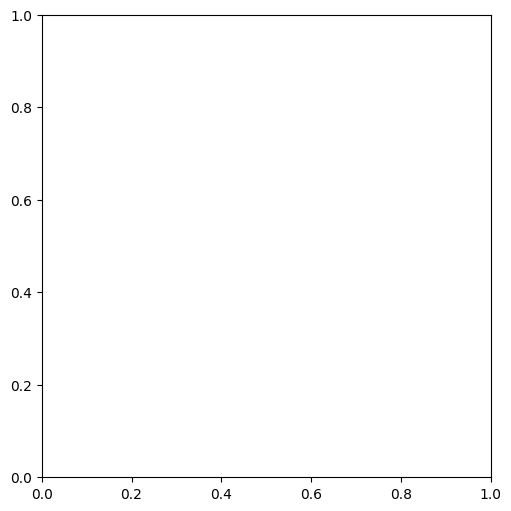

In [132]:
fig3

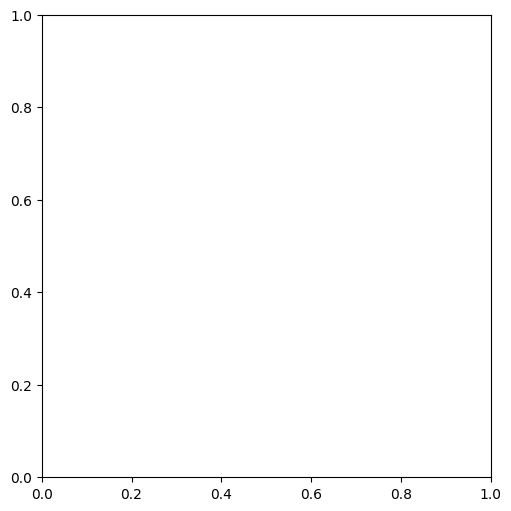

In [133]:
fig4